<a href="https://colab.research.google.com/github/pakpak123/predictRaintoday/blob/main/weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

สมาชิกกลุ่ม
*   63010524 นางสาวนิชาภา พักเง้า
*   63050100 นางสาวกิตติยา นิติธรธรรมกุล


# Australia Weather

## Data Description
| Variable | Definition |
| -------- | ---------- |
| Date | The date of observation |
| Location | The common name of the location of the weather station |
| MinTemp | The minimum temperature in degrees celsius |
| MaxTemp | The maximum temperature in degrees celsius |
| Sunshine | The number of hours of bright sunshine in the day |
| WindDir9am | Direction of the wind at 9am |
| WindSpeed9am | Wind speed (km/hr) averaged over 10 minutes prior to 9am |
| Humidity9am | Humidity (percent) at 9am |
| Pressure9am | Atmospheric pressure (hpa) reduced to mean sea level at 9am |
| Cloud9am | Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many |
| Temp9am | Temperature (degrees C) at 9am |

### Target Variable
- RainToday (Yes, No)

## Objective
- Clean ค่า null ถ้า column ไหนมี null มากกว่า 40% ให้แทนค่า null ด้วยค่า mean ของ column นั้นๆ
- สร้าง classification model เพื่อทำนาย RainToday

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import tree
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict


**นำเข้าไฟล์ weather_data_prepared.csv**

In [ ]:
admission_df = pd.read_csv("weather_data_prepared.csv")

# Read data

โดยใช้  head()   describe()  และ  info()  เพื่อการดูข้อมูลเบื้องต้น

In [ ]:
admission_df.head()

,Date,Location,MinTemp,MaxTemp,Sunshine,WindDir9am,WindSpeed9am,Humidity9am,Pressure9am,Cloud9am,Temp9am,RainToday
0,2008-12-01,Albury,13.4,22.9,NaN,W,20.0,71.0,1007.7,8.0,16.9,No
1,2008-12-02,Albury,7.4,25.1,NaN,NNW,4.0,44.0,1010.6,NaN,17.2,No
2,2008-12-03,Albury,12.9,25.7,NaN,W,19.0,38.0,1007.6,NaN,21.0,No
3,2008-12-04,Albury,9.2,28.0,NaN,SE,11.0,45.0,1017.6,NaN,18.1,No
4,2008-12-05,Albury,17.5,32.3,NaN,ENE,7.0,82.0,1010.8,7.0,17.8,No


In [ ]:
admission_df.describe()

,MinTemp,MaxTemp,Sunshine,WindSpeed9am,Humidity9am,Pressure9am,Cloud9am,Temp9am
count,143975.000000,144199.000000,75625.000000,143693.000000,142806.000000,130395.00000,89572.000000,143693.000000
mean,12.194034,23.221348,7.611178,14.043426,68.880831,1017.64994,4.447461,16.990631
std,6.398495,7.119049,3.785483,8.915375,19.029164,7.10653,2.887159,6.488753
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,980.50000,0.000000,-7.200000
25%,7.600000,17.900000,4.800000,7.000000,57.000000,1012.90000,1.000000,12.300000
50%,12.000000,22.600000,8.400000,13.000000,70.000000,1017.60000,5.000000,16.700000
75%,16.900000,28.200000,10.600000,19.000000,83.000000,1022.40000,7.000000,21.600000
max,33.900000,48.100000,14.500000,130.000000,100.000000,1041.00000,9.000000,40.200000


In [ ]:
admission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          145460 non-null  object 
 1   Location      145460 non-null  object 
 2   MinTemp       143975 non-null  float64
 3   MaxTemp       144199 non-null  float64
 4   Sunshine      75625 non-null   float64
 5   WindDir9am    134894 non-null  object 
 6   WindSpeed9am  143693 non-null  float64
 7   Humidity9am   142806 non-null  float64
 8   Pressure9am   130395 non-null  float64
 9   Cloud9am      89572 non-null   float64
 10  Temp9am       143693 non-null  float64
 11  RainToday     142199 non-null  object 
dtypes: float64(8), object(4)
memory usage: 13.3+ MB


**ตรวจสอบข้อมูลที่เป็นค่าว่าง**  (NaN )

In [ ]:
admission_df.isna().sum()

Date                0
Location            0
MinTemp          1485
MaxTemp          1261
Sunshine        69835
WindDir9am      10566
WindSpeed9am     1767
Humidity9am      2654
Pressure9am     15065
Cloud9am        55888
Temp9am          1767
RainToday        3261
dtype: int64

**ใช้ .shape เพื่อดูขนาดของข้อมูล**

In [ ]:
admission_df.shape

(145460, 12)

# **ตรวจสอบข้อมูลที่เป็น categorical feature** 
หรือข้อมูลที่ไม่ได้จัดเก็บเป็นตัวเลข

In [ ]:
#เก็บค่า columns ที่เป็น categorical feature ไว้ในตัวแปร categorical_feature
categorical_features = [column_name for column_name in admission_df if admission_df[column_name].dtype == 'O']
print("Name of Categorical Features : ",categorical_features)

Name of Categorical Features :  ['Date', 'Location', 'WindDir9am', 'RainToday']


In [ ]:
#Check number of unique  of each categorical features
for each_uni in categorical_features :
    print('Number of unique values of {} are : {}'.format(each_uni, len(admission_df[each_uni].unique())))

Number of unique values of Date are : 3436
Number of unique values of Location are : 49
Number of unique values of WindDir9am are : 17
Number of unique values of RainToday are : 3


จะเห็นว่า column Date มีค่า unique ที่ค่อนข้างสูง ซึ่งจะส่งผลกระทบต่อประสิทธิภาพของตัว model ดังนั้นจึงจำเป็นจะต้องลดค่า unique ให้น้อยลง โดยการเปลี่ยนประเภทของข้อมูล

In [ ]:
#Change data type of Date to datetime type
admission_df['Date'] = pd.to_datetime(admission_df['Date'])
admission_df['Date'].dtype

dtype('<M8[ns]')

In [ ]:
#Split Date to day , month , and year
admission_df['year'] = admission_df['Date'].dt.year
admission_df['month'] = admission_df['Date'].dt.month
admission_df['day'] = admission_df['Date'].dt.day

In [ ]:
#Drop unuse column (Date)
admission_df.drop('Date', axis=1 , inplace=True)

In [ ]:
admission_df.head()

,Location,MinTemp,MaxTemp,Sunshine,WindDir9am,WindSpeed9am,Humidity9am,Pressure9am,Cloud9am,Temp9am,RainToday,year,month,day
0,Albury,13.4,22.9,NaN,W,20.0,71.0,1007.7,8.0,16.9,No,2008,12,1
1,Albury,7.4,25.1,NaN,NNW,4.0,44.0,1010.6,NaN,17.2,No,2008,12,2
2,Albury,12.9,25.7,NaN,W,19.0,38.0,1007.6,NaN,21.0,No,2008,12,3
3,Albury,9.2,28.0,NaN,SE,11.0,45.0,1017.6,NaN,18.1,No,2008,12,4
4,Albury,17.5,32.3,NaN,ENE,7.0,82.0,1010.8,7.0,17.8,No,2008,12,5


เมื่อเราได้ทำการ convert data type ของ column Date เรียบร้อยแล้ว ต่อมาเราจะอัพเดทข้อมูลที่เป็น categorical features ใหม่อีกครั้ง

In [ ]:
categorical_features = [column_name for column_name in admission_df if admission_df[column_name].dtype == 'O']
print("Name of Categorical Features : ",categorical_features)

Name of Categorical Features :  ['Location', 'WindDir9am', 'RainToday']


## Fill ค่าว่างของ columns ที่เป็น categorical feature โดยใช้ mode()

In [ ]:
#fill null values in categorical_feature using mode()
for each_feature in categorical_features :
    admission_df[each_feature].fillna(admission_df[each_feature].mode()[0], inplace=True)

In [ ]:
admission_df[categorical_features].isna().sum()

Location      0
WindDir9am    0
RainToday     0
dtype: int64

# ตรวจสอบข้อมูลที่เป็น Numerical Features

In [ ]:
#เก็บค่า columns ที่เป็น numerical feature ไว้ในตัวแปร numerical_features
numerical_features = [column_name for column_name in admission_df if admission_df[column_name].dtype != 'O']
print("Name of Numerical Features : ",numerical_features)

Name of Numerical Features :  ['MinTemp', 'MaxTemp', 'Sunshine', 'WindSpeed9am', 'Humidity9am', 'Pressure9am', 'Cloud9am', 'Temp9am', 'year', 'month', 'day']


**Checking for outliner in Numerical feature**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

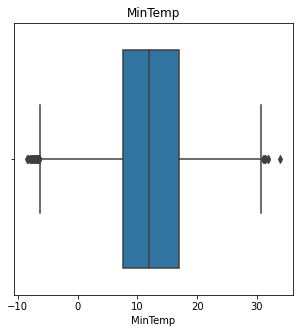

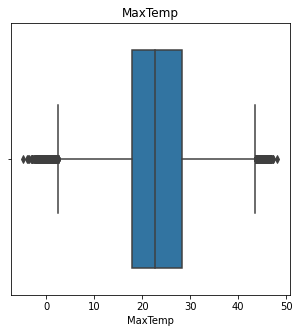

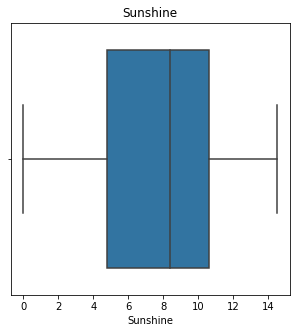

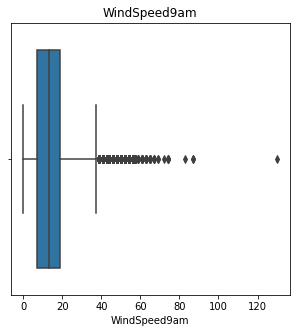

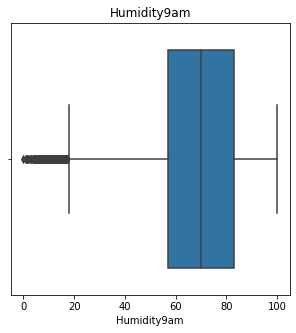

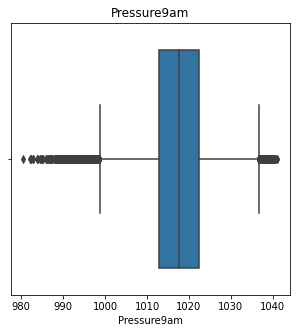

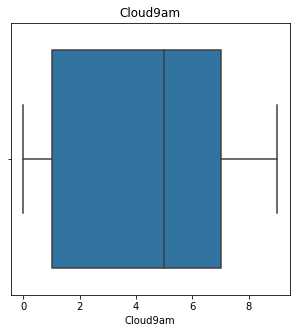

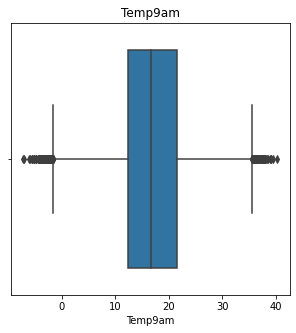

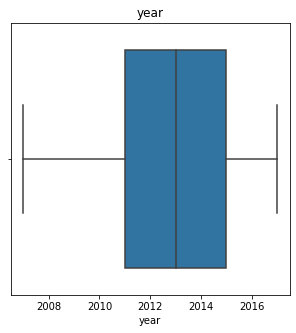

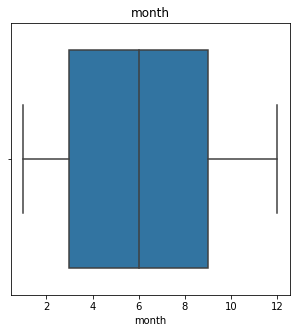

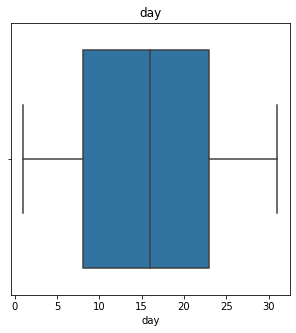

In [ ]:
#checking for outliner using Box plot
for feature in numerical_features :
    plt.figure(figsize=(5,5))
    sns.boxplot(admission_df[feature])
    plt.title(feature)

# **Remove outliner from numerical features**

In [ ]:
#features which has outliners
feature_has_outliner = ['MinTemp', 'MaxTemp' , 'WindSpeed9am', 'Humidity9am', 'Pressure9am', 'Temp9am']

In [ ]:
#replacing outliner using IQR
for feature in feature_has_outliner :
    q1 = admission_df[feature].quantile(0.25)
    q3 = admission_df[feature].quantile(0.75)
    IQR = q3-q1 #ค่าพิสัยระหว่างควอไทล์ (interquartile range)
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    admission_df.loc[admission_df[feature] < lower_limit, feature] = lower_limit
    admission_df.loc[admission_df[feature] > upper_limit, feature] = upper_limit

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

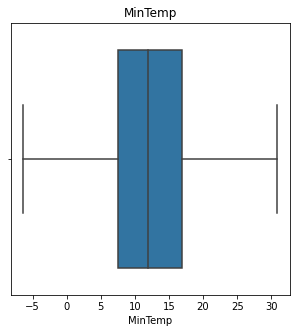

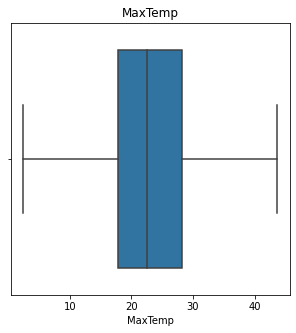

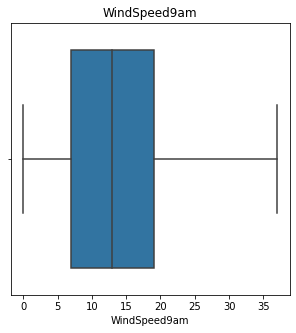

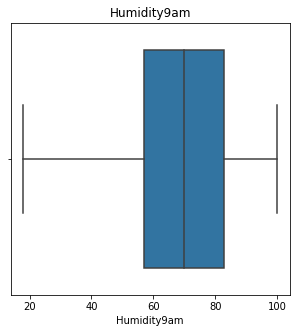

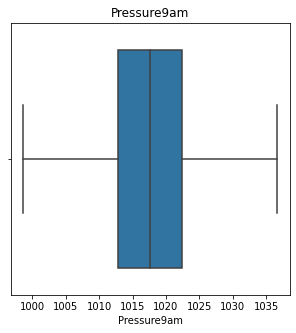

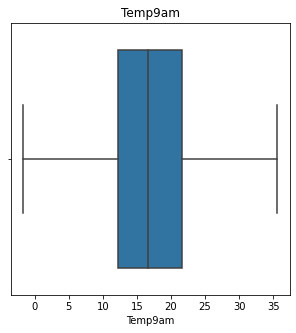

In [ ]:
#checking again to see if there is still has outliners in each numerical features
for feature in feature_has_outliner :
    plt.figure(figsize=(5,5))
    sns.boxplot(admission_df[feature])
    plt.title(feature)

## **Fill ค่าว่างด้วย mean ของ column นั้น**

ตรวจสอบว่าข้อมูลใน column ไหนที่มีค่าว่างมากกว่า 40% ของข้อมูลบ้าง  เราก็จะทำการ fill ค่าว่างนั้นด้วย mean ของ column นั้นๆ

In [ ]:
for column_name in admission_df :
    if(admission_df[column_name].isna().sum() > (0.4*(len(admission_df)))) :
        admission_df[column_name].fillna(admission_df[column_name].mean(), inplace = True)
        display('NaN values in column {} was fulfill by its mean'.format(column_name))
        display(admission_df[column_name])

'NaN values in column Sunshine was fulfill by its mean'

0         7.611178
1         7.611178
2         7.611178
3         7.611178
4         7.611178
            ...   
145455    7.611178
145456    7.611178
145457    7.611178
145458    7.611178
145459    7.611178
Name: Sunshine, Length: 145460, dtype: float64

fill ข้อมูลใน columns ที่เหลือโดยใช้ mean() เช่นกัน

In [ ]:
for column_name in numerical_features :
    admission_df[column_name].fillna(admission_df[column_name].mean(), inplace=True)

In [ ]:
admission_df[numerical_features].isna().sum()

MinTemp         0
MaxTemp         0
Sunshine        0
WindSpeed9am    0
Humidity9am     0
Pressure9am     0
Cloud9am        0
Temp9am         0
year            0
month           0
day             0
dtype: int64

กราฟแสดงข้อมูลในแต่ละ columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0588e120d0>,
      dtype=object)

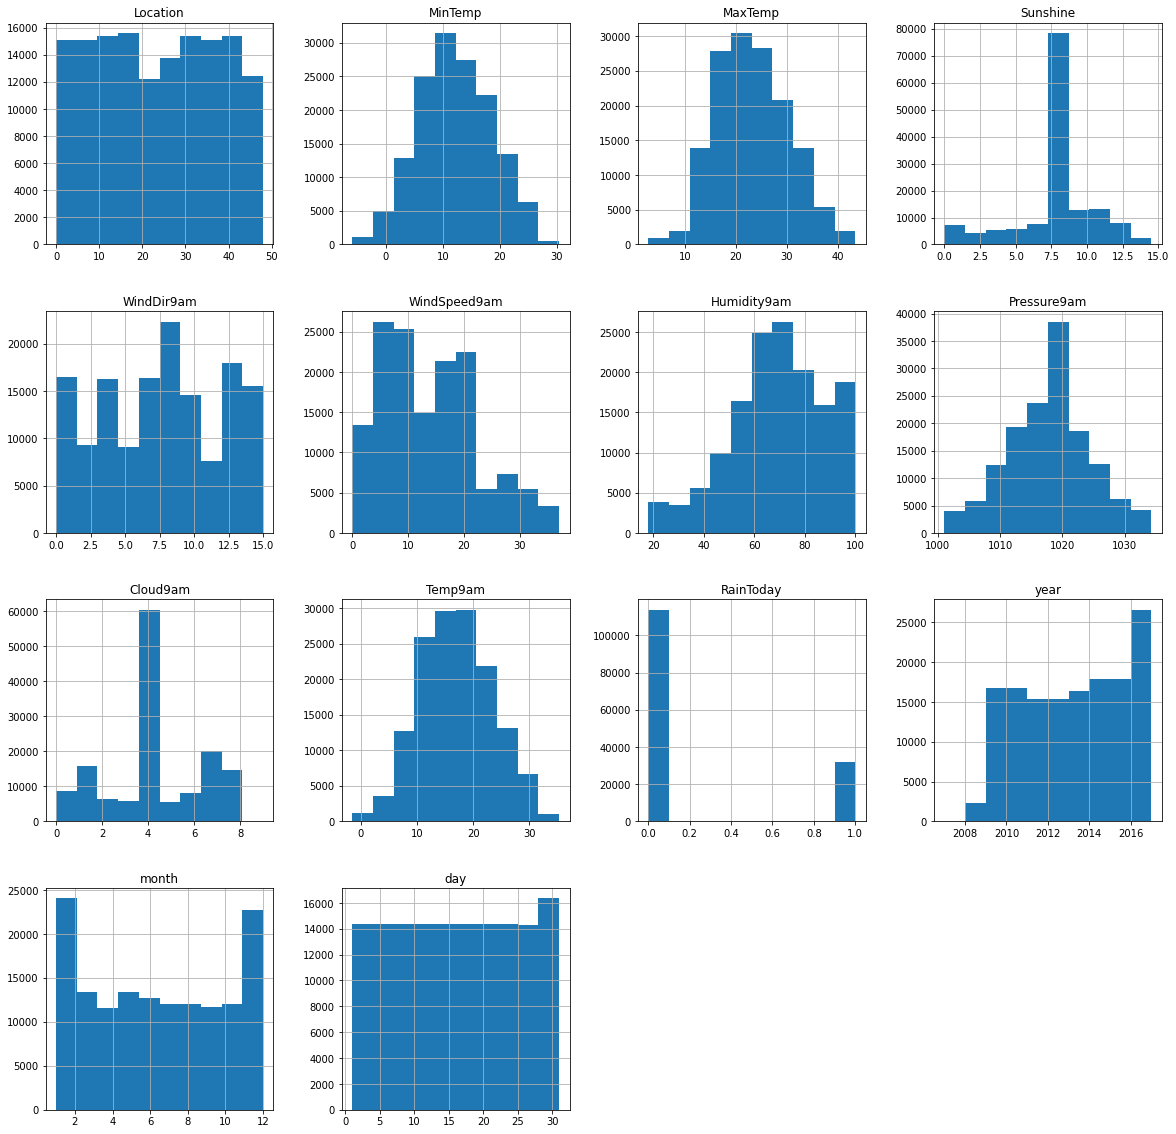

In [ ]:
admission_df[numerical_features].hist(bins=10,figsize=(20,20))

# ดูความสัมพันธ์ของข้อมูล

In [ ]:
#see correlation using .corr()
admission_df.corr()

,Location,MinTemp,MaxTemp,Sunshine,WindDir9am,WindSpeed9am,Humidity9am,Pressure9am,Cloud9am,Temp9am,RainToday,year,month,day
Location,1.000000,0.068929,0.101898,0.048676,-0.015583,0.076143,-0.140211,-0.094839,-0.049721,0.111947,-0.007359,0.026622,0.004935,-0.000057
MinTemp,0.068929,1.000000,0.733379,0.051296,-0.022108,0.177538,-0.230711,-0.432680,0.062157,0.897780,0.054589,0.043010,-0.202753,0.002338
MaxTemp,0.101898,0.733379,1.000000,0.329751,0.030111,0.017170,-0.497130,-0.319101,-0.225832,0.879387,-0.225273,0.061736,-0.163198,0.000656
Sunshine,0.048676,0.051296,0.329751,1.000000,0.008854,0.006782,-0.349320,0.028877,-0.532497,0.208726,-0.235296,0.006072,0.017589,-0.000286
WindDir9am,-0.015583,-0.022108,0.030111,0.008854,1.000000,-0.024693,-0.018373,-0.005582,-0.024048,0.006926,-0.040339,0.007230,0.012605,0.007095
WindSpeed9am,0.076143,0.177538,0.017170,0.006782,-0.024693,1.000000,-0.273399,-0.213510,0.018119,0.131750,0.098274,-0.017855,0.051481,-0.008879
Humidity9am,-0.140211,-0.230711,-0.497130,-0.349320,-0.018373,-0.273399,1.000000,0.134553,0.354042,-0.468511,0.348419,0.009745,-0.089070,0.015121
Pressure9am,-0.094839,-0.432680,-0.319101,0.028877,-0.005582,-0.213510,0.134553,1.000000,-0.100832,-0.407458,-0.174517,0.028147,0.035301,-0.019914
Cloud9am,-0.049721,0.062157,-0.225832,-0.532497,-0.024048,0.018119,0.354042,-0.100832,1.000000,-0.109049,0.243208,0.051533,-0.007930,0.005702
Temp9am,0.111947,0.897780,0.879387,0.208726,0.006926,0.131750,-0.468511,-0.407458,-0.109049,1.000000,-0.095691,0.045690,-0.135287,0.000181


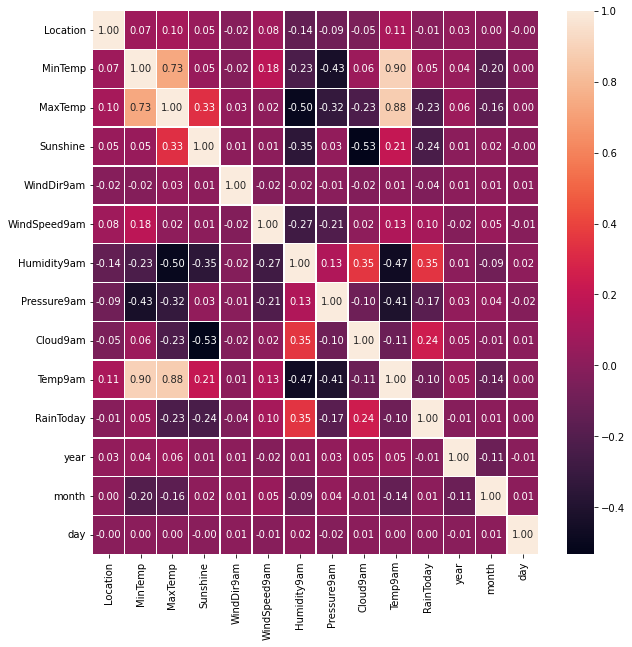

In [ ]:
#see correlation using heatmap
plt.figure(figsize=(10,10))
sns.heatmap(admission_df.corr(),linewidths=0.5, annot=True, fmt='.2f')

# Encoding of categorical feature

In [ ]:
categorical_features

['Location', 'WindDir9am', 'RainToday']

**เปลี่ยนค่า Yes -> 1 และ No -> 0 ใน columns RainToday**

In [ ]:
admission_df.replace({'RainToday' : {'Yes' : 1 , 'No' : 0}}, inplace=True)

In [ ]:
#create function for encoding of each categorical features
def encode_categorical_data(features_name) :
    mapping_dict = {}
    uni_val = list(admission_df[features_name].unique())
    for i in range(len(uni_val)):
        mapping_dict[uni_val[i]] = i
    display(mapping_dict)
    return mapping_dict

In [ ]:
#encoding of categorical data in column Location
admission_df['Location'].replace(encode_categorical_data('Location'), inplace=True)

{'Adelaide': 32,
 'Albany': 36,
 'Albury': 0,
 'AliceSprings': 45,
 'BadgerysCreek': 1,
 'Ballarat': 18,
 'Bendigo': 19,
 'Brisbane': 28,
 'Cairns': 29,
 'Canberra': 15,
 'Cobar': 2,
 'CoffsHarbour': 3,
 'Dartmoor': 27,
 'Darwin': 46,
 'GoldCoast': 30,
 'Hobart': 43,
 'Katherine': 47,
 'Launceston': 44,
 'Melbourne': 22,
 'MelbourneAirport': 21,
 'Mildura': 23,
 'Moree': 4,
 'MountGambier': 33,
 'MountGinini': 17,
 'Newcastle': 5,
 'Nhil': 24,
 'NorahHead': 6,
 'NorfolkIsland': 7,
 'Nuriootpa': 34,
 'PearceRAAF': 38,
 'Penrith': 8,
 'Perth': 40,
 'PerthAirport': 39,
 'Portland': 25,
 'Richmond': 9,
 'Sale': 20,
 'SalmonGums': 41,
 'Sydney': 10,
 'SydneyAirport': 11,
 'Townsville': 31,
 'Tuggeranong': 16,
 'Uluru': 48,
 'WaggaWagga': 12,
 'Walpole': 42,
 'Watsonia': 26,
 'Williamtown': 13,
 'Witchcliffe': 37,
 'Wollongong': 14,
 'Woomera': 35}

In [ ]:
#encoding of categorical data in column WindDir9am
admission_df['WindDir9am'].replace(encode_categorical_data('WindDir9am'), inplace=True)

{'E': 12,
 'ENE': 3,
 'ESE': 11,
 'N': 8,
 'NE': 7,
 'NNE': 15,
 'NNW': 1,
 'NW': 13,
 'S': 6,
 'SE': 2,
 'SSE': 5,
 'SSW': 9,
 'SW': 4,
 'W': 0,
 'WNW': 14,
 'WSW': 10}

In [ ]:
admission_df.head()

,Location,MinTemp,MaxTemp,Sunshine,WindDir9am,WindSpeed9am,Humidity9am,Pressure9am,Cloud9am,Temp9am,RainToday,year,month,day
0,0,13.4,22.9,7.611178,0,20.0,71.0,1007.7,8.000000,16.9,0,2008,12,1
1,0,7.4,25.1,7.611178,1,4.0,44.0,1010.6,4.447461,17.2,0,2008,12,2
2,0,12.9,25.7,7.611178,0,19.0,38.0,1007.6,4.447461,21.0,0,2008,12,3
3,0,9.2,28.0,7.611178,2,11.0,45.0,1017.6,4.447461,18.1,0,2008,12,4
4,0,17.5,32.3,7.611178,3,7.0,82.0,1010.8,7.000000,17.8,0,2008,12,5


In [ ]:
admission_df.shape

(145460, 14)

# Train Test Split

กำหนดตัวแปรต้น (X)  และตัวแปรตาม (y)

In [ ]:
X = admission_df.drop(['RainToday'] , axis = 1)
y = admission_df['RainToday']

Location        0.063462
MinTemp         0.099112
MaxTemp         0.099055
Sunshine        0.049753
WindDir9am      0.054859
WindSpeed9am    0.071152
Humidity9am     0.179548
Pressure9am     0.096618
Cloud9am        0.058004
Temp9am         0.062587
year            0.052161
month           0.057174
day             0.056515
dtype: float64

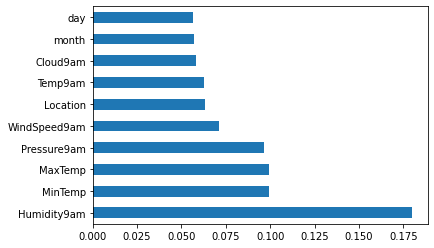

In [ ]:
#ดูว่า feature ไหนมีความสำคัญมากที่สุด
etr_model = ExtraTreesRegressor()
etr_model.fit(X,y)
etr_model.feature_importances_

feature_imp = pd.Series(etr_model.feature_importances_, index=X.columns)
feature_imp.nlargest(10).plot(kind='barh')
feature_imp

สร้าง Training Data และ Testing Data โดยกำหนด test_size=0.3

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
print("Length of Training Data: {}".format(len(X_train)))
print("Length of Testing Data: {}".format(len(X_test)))

Length of Training Data: 101822
Length of Testing Data: 43638


# Logistic Regression
Train model Logistic Regression โดยกำหนด solver='liblinear'

In [ ]:
# Create model named 'clf_lr' - use solver='liblinear'
clf_lr = LogisticRegression(solver='liblinear')

# Train model
clf_lr.fit(X_train,y_train)

# Predict named 'lr_y_pred'
lr_y_pred = clf_lr.predict(X_test)

**คำนวณ Cross-validation**

In [ ]:
print(f'Test data accuracy score: {np.round(clf_lr.score(X_test, y_test), 2)*100}%')

Test data accuracy score: 83.0%


In [ ]:
print(f'Cross val score : {np.mean(cross_val_score(clf_lr, X,y, cv=5, n_jobs=-1)).round(2)}')

Cross val score : 0.82


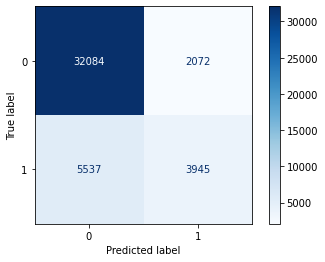

In [ ]:
#Confision matrix
plot_confusion_matrix(clf_lr, X_test, y_test, cmap='Blues', values_format='d')

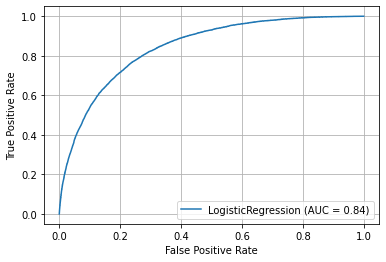

In [ ]:
#AUC ROC curve
plot_roc_curve(clf_lr, X_test, y_test)
plt.grid()

ตรวจสอบค่า Coefficient of model

In [ ]:
clf_lr.coef_

array([[ 0.00298715,  0.16741829, -0.20308929, -0.00653168, -0.01507408,
         0.02897547,  0.06063118, -0.06273958,  0.01095971,  0.03521819,
         0.02940259,  0.0430168 , -0.00109325]])

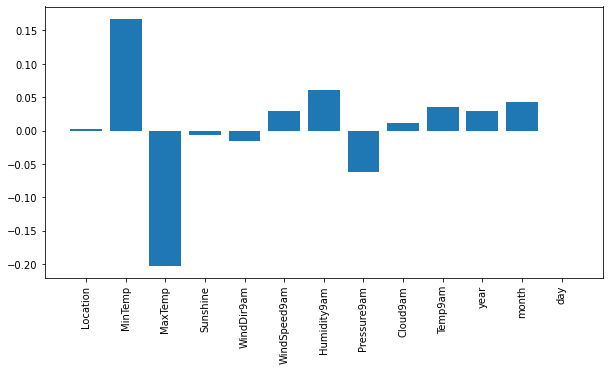

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(X_train.columns, clf_lr.coef_[0])
plt.xticks(rotation=90)
plt.show()

# Decision Tree

Train model Decision Tree

In [ ]:
#Create model named 'clf_dt'
clf_dt = DecisionTreeClassifier()

#Train model
clf_dt = clf_dt.fit(X_train, y_train)

#Predict named 'dt_y_pred'
dt_y_pred = clf_dt.predict(X_test)

**คำนวณ Cross-validation**

In [ ]:
#Print Test data accuracy score
print(f'Test data accuracy score : {np.round(clf_dt.score(X_test, y_test),2)*100}%')

#ใช้ cross_val_score เพื่อคำนวณ Cross-Validation
dt_cross_val = cross_val_score(clf_dt, X, y, cv=10, n_jobs=-1)

#เรียกดูค่า Cross-Validation ในแต่ละรอบ
print('Cross val score')
for i in range(len(dt_cross_val)) :
    print(f'Fold {i+1} : {dt_cross_val[i]}')

#แสดงค่าเฉลี่ย Cross-Validation score
print(f'Mean Cross val score : {np.mean(dt_cross_val)}')

Test data accuracy score : 78.0%
Cross val score
Fold 1 : 0.7865392547779458
Fold 2 : 0.6594940189742885
Fold 3 : 0.7450158119070535
Fold 4 : 0.7232916265640038
Fold 5 : 0.7492094046473258
Fold 6 : 0.6352261790182868
Fold 7 : 0.7577340849718136
Fold 8 : 0.739378523305376
Fold 9 : 0.777808332187543
Fold 10 : 0.7696961363948852
Mean Cross val score : 0.7343393372748521


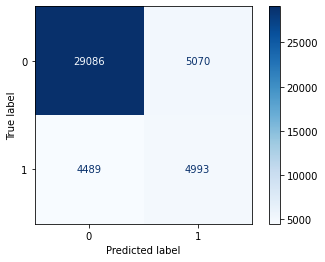

In [ ]:
#Confusion matrix
plot_confusion_matrix(clf_dt, X_test,y_test, cmap='Blues', values_format='d')

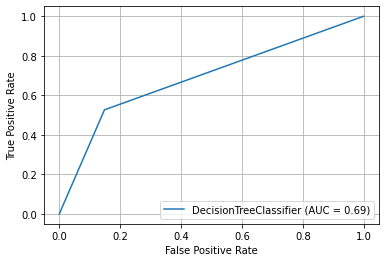

In [ ]:
#AOC ROC curve
plot_roc_curve(clf_dt,X_test,y_test)
plt.grid()

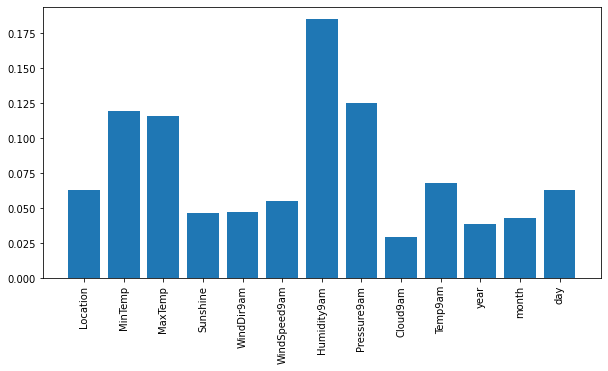

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(X_train.columns, clf_dt.feature_importances_)
plt.xticks(rotation=90)
plt.show()

# SVM

Train SVM model ด้วย svm.SVC() 

In [ ]:
#Create model named 'clf_svm'
clf_svm = svm.SVC(max_iter=5000, kernel='linear', C=2)

#Fit model
clf_svm.fit(X_train, y_train)

#Predict named 'svm_y_pred'
svm_y_pred = clf_svm.predict(X_test)

print(f'Test data accuracy score : {np.round(clf_svm.score(X_test, y_test),2)*100}%')

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Test data accuracy score : 63.0%


In [ ]:
#Create model named 'clf_svm'
clf_svm = svm.SVC(max_iter=5000, kernel='linear', C=10)

#Fit model
clf_svm.fit(X_train, y_train)

print(f'Test data accuracy score : {np.round(clf_svm.score(X_test, y_test),2)*100}%')

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Test data accuracy score : 66.0%


# KNN

Train model KNN ด้วย KNeighborsClassifier()

In [ ]:
k = 5

#Create model named 'clf_knn'
clf_knn = KNeighborsClassifier(n_neighbors=k)

#Fit model
clf_knn.fit(X_train, y_train)

#Predict named 'knn_y_pred'
knn_y_pred = clf_knn.predict(X_test)

print(f'Test data accuracy score (K = {k}):{np.round(clf_knn.score(X_test, y_test),2 )*100}%')

Test data accuracy score (K = 5):83.0%


คำนวณ Cross validation score

In [ ]:
#ใช้ cross_val_score เพื่อคำนวณ Cross-validation
knn_cv = cross_val_score(clf_knn, X,y,cv=10)

#แสดงค่า Cross-validation ในแต่ละรอบ
for i in range(len(knn_cv)) :
    print('Fold %s : %s' %(i, knn_cv[i]))

#แสดงค่าเฉลี่ยของ Cross-validation
print("Mean cross val score : ",np.mean(knn_cv))

Fold 0 : 0.8238691049085659
Fold 1 : 0.756152894266465
Fold 2 : 0.8131445070809845
Fold 3 : 0.785233053760484
Fold 4 : 0.8015949401897429
Fold 5 : 0.7910765846280764
Fold 6 : 0.7906641000962464
Fold 7 : 0.7892204042348412
Fold 8 : 0.8046885741784683
Fold 9 : 0.8230441358449058
Mean cross val score :  0.797868829918878


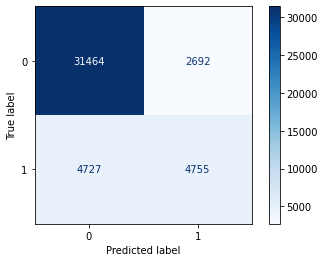

In [ ]:
#วาด Confusion matrix
plot_confusion_matrix(clf_knn, X_test,y_test, cmap='Blues', values_format='d')

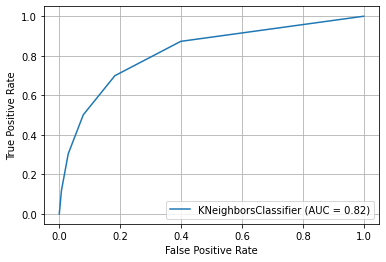

In [ ]:
#AUC ROC curve
plot_roc_curve(clf_knn, X_test, y_test)
plt.grid()

# Random Forest

Train model ด้วย RandomForestClassifier()

In [ ]:
#random forest(iii)
clf_rf=RandomForestClassifier()

#Fit model
clf_rf.fit(X_train,y_train)

#Predict named 'rf_y_pred'
rf_y_pred = clf_rf.predict(X_test)

คำนวณ Cross validation score

In [ ]:
#Print Test data accuracy score
print(f'Test data accuracy score : {np.round(clf_rf.score(X_test, y_test),2)*100}%')

#ใช้ cross_val_score เพื่อคำนวณ Cross-Validation
rf_cross_val = cross_val_score(clf_rf, X, y, cv=10, n_jobs=-1)

#เรียกดูค่า Cross-Validation ในแต่ละรอบ
print('Cross val score')
for i in range(len(rf_cross_val)) :
    print(f'Fold {i+1} : {rf_cross_val[i]}')

#แสดงค่าเฉลี่ย Cross-Validation score
print(f'Mean Cross val score : {np.mean(rf_cross_val)}')

Test data accuracy score : 85.0%
Cross val score
Fold 1 : 0.8429808882166919
Fold 2 : 0.799876254640451
Fold 3 : 0.8318438058572803
Fold 4 : 0.8079197030111371
Fold 5 : 0.8304688574178468
Fold 6 : 0.8308813419496769
Fold 7 : 0.8159631513818232
Fold 8 : 0.8375498418809295
Fold 9 : 0.8158944039598515
Fold 10 : 0.8351436821119208
Mean Cross val score : 0.8248521930427609


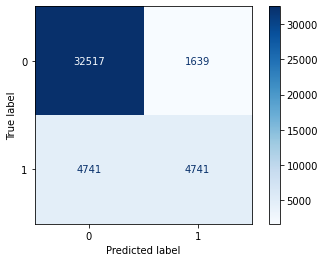

In [ ]:
#วาด Confusion matrix
plot_confusion_matrix(clf_rf, X_test,y_test, cmap='Blues', values_format='d')

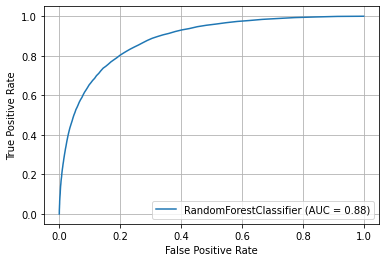

In [ ]:
#AUC ROC curve
plot_roc_curve(clf_rf, X_test, y_test)
plt.grid()

Classification Model ที่ให้ผลลัพธ์ดีที่สุดคือ Random Forest

# Ensemble

ทำ Majority Vote เพื่อเลือกผลลัพธ์ที่ Model ทำนายออกมาเหมือนกันมากที่สุด

In [ ]:
#สร้าง Data frame ของค่า predict แต่ละ model
voting_df = pd.DataFrame({'lr' : lr_y_pred, 'dt1' : dt_y_pred,
                                        'rf' : rf_y_pred, 'svm' : svm_y_pred,
                                        'knn' : knn_y_pred})

In [ ]:
voting_df

,lr,dt1,rf,svm,knn
0,1,1,1,1,1
1,0,1,1,1,1
2,0,0,0,0,0
3,0,1,0,0,0
4,1,1,0,1,0
...,...,...,...,...,...
43633,0,0,0,1,0
43634,0,0,0,0,0
43635,0,0,0,0,0
43636,1,0,1,1,1


หาผลรวมการทำนายของทุก model

In [ ]:
voting_df = voting_df.sum(axis=1)

In [ ]:
voting_df

0        5
1        4
2        0
3        1
4        3
        ..
43633    1
43634    0
43635    0
43636    4
43637    1
Length: 43638, dtype: int64

สร้างผลลัพธ์โดยกำหนดว่าถ้าผลรวมการทำนาย >=3 ให้ทำนายเป็น 1 ถ้าไม่ใช่ = 0

In [ ]:
result = voting_df.apply(lambda x : 1 if x>=3 else 0)

In [ ]:
print('Result : ',result)
print('\nAccuracy score : ',accuracy_score(y_test,result))

Result :  0        1
1        1
2        0
3        0
4        1
        ..
43633    0
43634    0
43635    0
43636    1
43637    0
Length: 43638, dtype: int64

Accuracy score :  0.8441954260048582


กราฟแสดงผลการทำนาย

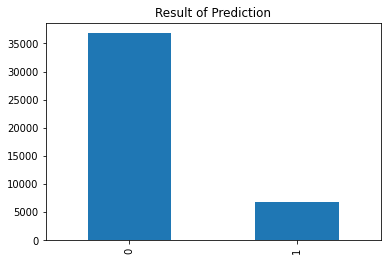

In [ ]:
#Plot result
plt.title("Result of Prediction")
result.value_counts().plot(kind='bar')